In [14]:
import psycopg2
import pandas as pd
from datetime import datetime, timedelta

# 建立数据库连接
conn = psycopg2.connect(
    dbname="day_ahead_spot",
    user="tupo",
    password="npg_mbhaH6B3jdzy",
    host="ep-bold-king-a52tlxdq-pooler.us-east-2.aws.neon.tech",
    port="5432"
)

In [15]:
query = "SELECT * FROM day_ahead_marginal_data;"
df = pd.read_sql_query(query, conn)

/var/folders/c_/cnt9g3l16nd_mqc7h_h8_m280000gn/T/ipykernel_3028/2756668864.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [44]:
from decimal import Decimal

def estimate_clearing_price(conn, query_date, time_slot, rate_tolerance=0.01, lookback_days=5):
    rate_tolerance = Decimal(str(rate_tolerance))  # 把 float 转为 Decimal
    
    # 获取目标负荷率
    query = f"""
        SELECT day_ahead_load_rate_percent
        FROM day_ahead_marginal_data
        WHERE date = %s AND time_slot = %s
    """
    with conn.cursor() as cur:
        cur.execute(query, (query_date, time_slot))
        result = cur.fetchone()
        if not result:
            return None
        target_rate = result[0]  # 这是 Decimal 类型

    # 查找近几天内相同时点且负荷率相近的数据
    start_date = query_date - timedelta(days=lookback_days)
    match_query = f"""
        SELECT day_ahead_clearing_price
        FROM day_ahead_marginal_data
        WHERE 
            date >= %s AND date < %s
            AND day_ahead_load_rate_percent BETWEEN %s AND %s
    """
    with conn.cursor() as cur:
        cur.execute(match_query, (
            start_date, query_date,
            target_rate - rate_tolerance,
            target_rate + rate_tolerance
        ))
        # print("Executing query:", match_query)
        # print("With parameters:", start_date, query_date, time_slot, target_rate - rate_tolerance, target_rate + rate_tolerance)

        prices = [row[0] for row in cur.fetchall()]
        return sum(prices) / len(prices) if prices else None

In [45]:
target_date = datetime.strptime("2025-03-30", "%Y-%m-%d").date()
test = estimate_clearing_price(conn,target_date, "00:15:00",1,5)
print(test)

395.3727272727272727272727273


In [48]:
# 假设处理目标日期为 2025-03-30
target_date = datetime.strptime("2025-03-30", "%Y-%m-%d").date()

# 生成所有96个时点（15分钟一个）
time_slots = [f"{hour:02}:{minute:02}:00" 
              for hour in range(24) 
              for minute in range(0, 60, 15)]

results = []
for time_str in time_slots:
    time_slot = datetime.strptime(time_str, "%H:%M:%S").time()
    avg_price = estimate_clearing_price(conn, target_date, time_slot,1)
    results.append({
        "date": target_date,
        "time_slot": time_slot,
        "estimated_price": avg_price
    })

result_df = pd.DataFrame(results)

In [49]:
result_df

,date,time_slot,estimated_price
0,2025-03-30,00:00:00,332.192
1,2025-03-30,00:15:00,395.3727272727272727272727273
2,2025-03-30,00:30:00,340.22
3,2025-03-30,00:45:00,433.045
4,2025-03-30,01:00:00,433.045
...,...,...,...
91,2025-03-30,22:45:00,442.1666666666666666666666667
92,2025-03-30,23:00:00,402.2623076923076923076923077
93,2025-03-30,23:15:00,348.5533333333333333333333333
94,2025-03-30,23:30:00,395.3727272727272727272727273


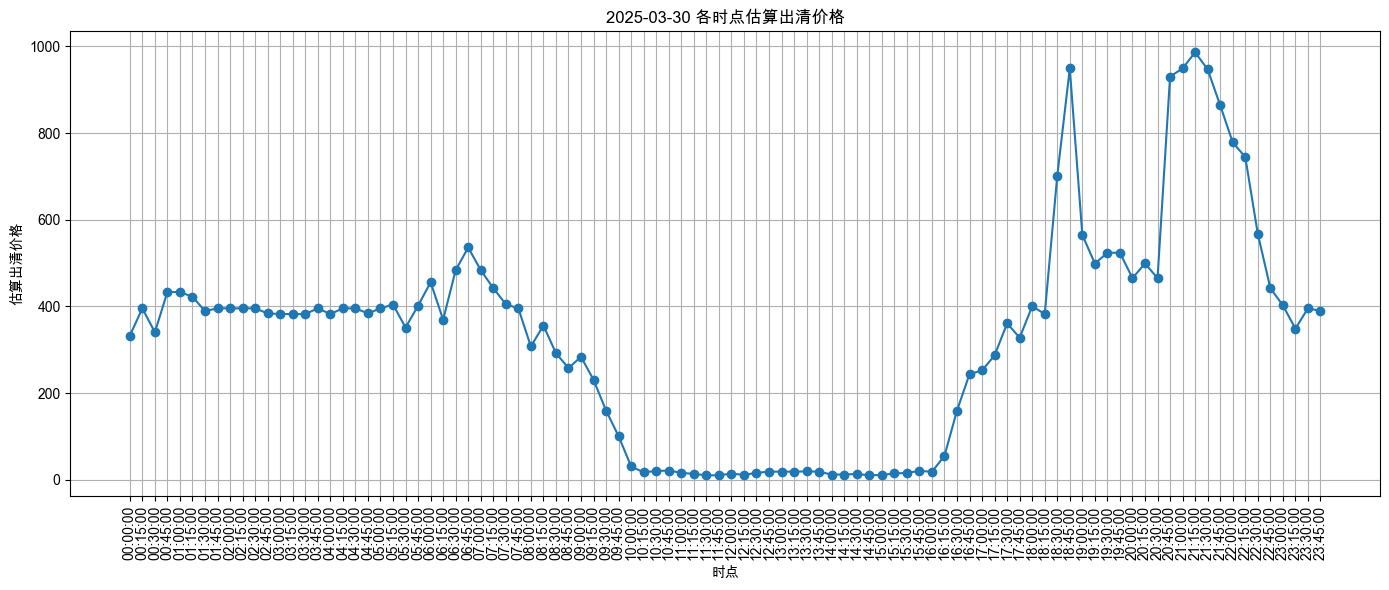

In [51]:
import matplotlib.pyplot as plt

# 转换 time_slot 为字符串，用作横坐标
result_df["time_str"] = result_df["time_slot"].astype(str)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 设置默认字体
plt.rcParams['axes.unicode_minus'] = False              # 解决负号显示问题
# 绘图
plt.figure(figsize=(14, 6))
plt.plot(result_df["time_str"], result_df["estimated_price"], marker='o')
plt.title(f"{result_df['date'].iloc[0]} 各时点估算出清价格")
plt.xlabel("时点")
plt.ylabel("估算出清价格")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
conn.close()